[View in Colaboratory](https://colab.research.google.com/github/korrawe/exxon_training/blob/master/Lab_classification.ipynb)

## Install this package before starting this lab

In [1]:
!pip install xlrd
!pip install pydot
!pip install pyparsing
!apt-get install graphviz
!pip install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


## Import libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier, plot_tree, plot_importance

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15

In [0]:
from google.colab import files
import io 

# uploaded = files.upload()

# XGboost

In [0]:
# Load our pre-processed data
df = pd.read_csv('data.csv')

In [5]:
print(df.shape)
df.head()

(4591, 19)


,SerialNumber,Leave,ActionYear,WorkDurationYear,CountLoan,Avg_MonthPerLoan,HireType,HireSourceGroup,WorkDurationYear.1,Avg_TotalAbsensePerYear,Avg_NumDaysPerAbsense,TotalEduAllowance,NumYear_SinceLastEduAllowance,TotalEduAttend,EduBranch_CHEM,EduBranch_Finance,EduBranch_Languages,Max_EduInstituteGroup,NumYear_SinceLastEdu
0,4,1.0,2000,39.0,0.0,0.0,Unknown,Unknown,39.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Unknown,41.0
1,5,1.0,2000,39.0,0.0,0.0,Unknown,Unknown,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UNIV,40.0
2,6,1.0,2000,38.0,0.0,0.0,Unknown,Unknown,38.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Unknown,47.0
3,7,1.0,2000,38.0,0.0,0.0,Unknown,Unknown,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SCHL,39.0
4,10,1.0,2000,38.0,0.0,0.0,Unknown,Unknown,38.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Unknown,38.0


In [6]:
# Print columns in dataframe
print(df.columns.values)

['SerialNumber' 'Leave' 'ActionYear' 'WorkDurationYear' 'CountLoan'
 'Avg_MonthPerLoan' 'HireType' 'HireSourceGroup' 'WorkDurationYear.1'
 'Avg_TotalAbsensePerYear' 'Avg_NumDaysPerAbsense' 'TotalEduAllowance'
 'NumYear_SinceLastEduAllowance' 'TotalEduAttend' 'EduBranch_CHEM'
 'EduBranch_Finance' 'EduBranch_Languages' 'Max_EduInstituteGroup'
 'NumYear_SinceLastEdu']


In [0]:
# Create one-hot feature columns for Max_EduInstituteGroup, HireType, HireSourceGroup
dfEduInstituteGroup = pd.get_dummies(df['Max_EduInstituteGroup'], prefix='Max_EduInstituteGroup')
dfHireTypeGroup = pd.get_dummies(df['HireType'], prefix='HireType')
dfHireSourceGroup = pd.get_dummies(df['HireSourceGroup'], prefix='HireSourceGroup')

# Concat the new columns to the dataframe
df = pd.concat([df, dfEduInstituteGroup, dfHireTypeGroup, dfHireSourceGroup], axis=1)

In [8]:
print(df.shape)

(4591, 40)


We will try to use xgboost model to predict whether an employee is still working for the company after 2017. Similar to our previous labs, we devide our train and test set using ActionYear 2017

In [9]:
df_train = df[ df['ActionYear'] < 2017]
df_train.shape

(3469, 40)

In [10]:
df_test = df[ df['ActionYear'] >= 2017]
df_test.shape

(1122, 40)

In [0]:
# Drop irrelavent columns and create label
df_train_variable = df_train.drop(['SerialNumber','ActionYear','Leave','Max_EduInstituteGroup','HireType','HireSourceGroup'],axis=1)
df_train_label = df_train['Leave']

df_test_variable = df_test.drop(['SerialNumber','ActionYear','Leave','Max_EduInstituteGroup','HireType','HireSourceGroup'],axis=1)
df_test_label = df_test['Leave']

In [0]:
X_train, X_test, y_train, y_test = df_train_variable, df_test_variable, df_train_label, df_test_label

In [13]:
print(y_train.shape)
print(y_test.shape)

(3469,)
(1122,)


Here, we create our xgboost classifier that will classify 2 classes, whether each employee will leave the company by the end of 2017, with some pre-defined hyperparameters. Note that these hyperparameters should be tuned for each different task and dataset.

Full details of each hyperparameter can be found in [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)

In [0]:
# Define our model
model = XGBClassifier(    
    n_jobs=16,
    n_estimators=400,
    max_depth=4,
    objective="binary:logistic",
    learning_rate=0.07, 
    subsample=0.9,
    min_child_weight=6,
    colsample_bytree=.9,
    scale_pos_weight=0.8,
    gamma=8,
    reg_alpha=6,
    reg_lambda=1.3)

In [15]:
# Train the model
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=8, learning_rate=0.07, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=400,
       n_jobs=16, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=6, reg_lambda=1.3, scale_pos_weight=0.8,
       seed=None, silent=True, subsample=0.9)


#### Predict test labels for model evaluation
By calling predict_proba(input_data), the model will output the probabilities of each output class

In [16]:
model.predict_proba(X_test)

array([[0.8323903 , 0.16760969],
       [0.8410598 , 0.15894018],
       [0.8323903 , 0.16760969],
       ...,
       [0.5864377 , 0.41356227],
       [0.62527406, 0.37472597],
       [0.6257338 , 0.3742662 ]], dtype=float32)

In [0]:
# Predict test label for model evaluation
# Since we only have 2 classes, 0 and 1, we will use predict_proba(X_test)[:,1] as probability of employees levaing the company
y_pred = model.predict_proba(X_test)[:,1]

# Round the predicted probabilities to get predicted labels
predictions = [np.round(value) for value in y_pred]

In [18]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

        0.0       0.91      0.78      0.84       959
        1.0       0.28      0.52      0.37       163

avg / total       0.82      0.74      0.77      1122



In [19]:
print(confusion_matrix(y_test, predictions))

[[745 214]
 [ 78  85]]


----------

## Target Encoding
In case that we have categorical features columns, e.g user group is 1, 2, or 3, we usually create new one-hot feature columns for all possible categories which will have value '1' in the column that user belong and '0' otherwise. However, by creating new one-hot feature columns for every categories, we will end up with a lot of one-hot feature columns that might be hard to learn by the model.

In this section, we will encode those categorical features into a new columns that will be easier to be learned by the model

In [0]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    # Apply average function to all target data
    prior = target.mean()
    
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index

    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

## Train new model with target encoding

In [0]:
# Load our pre-processed data
df = pd.read_csv('data.csv')

In [22]:
df.dtypes

SerialNumber                       int64
Leave                            float64
ActionYear                         int64
WorkDurationYear                 float64
CountLoan                        float64
Avg_MonthPerLoan                 float64
HireType                          object
HireSourceGroup                   object
WorkDurationYear.1               float64
Avg_TotalAbsensePerYear          float64
Avg_NumDaysPerAbsense            float64
TotalEduAllowance                float64
NumYear_SinceLastEduAllowance    float64
TotalEduAttend                   float64
EduBranch_CHEM                   float64
EduBranch_Finance                float64
EduBranch_Languages              float64
Max_EduInstituteGroup             object
NumYear_SinceLastEdu             float64
dtype: object

In [0]:
# Create one-hot feature columns for Max_EduInstituteGroup, HireType, HireSourceGroup
dfEduInstituteGroup = pd.get_dummies(df['Max_EduInstituteGroup'], prefix='Max_EduInstituteGroup')
dfHireTypeGroup = pd.get_dummies(df['HireType'], prefix='HireType')
dfHireSourceGroup = pd.get_dummies(df['HireSourceGroup'], prefix='HireSourceGroup')

# Concat the new columns to the dataframe
df = pd.concat([df, dfEduInstituteGroup,dfHireTypeGroup,dfHireSourceGroup], axis=1)

In [0]:
# Split train/test 
df_train = df[ df['ActionYear'] < 2017]
df_train.shape

df_test = df[ df['ActionYear'] >= 2017]
df_test.shape

df_train_variable = df_train.drop(['SerialNumber','ActionYear','Leave'],axis=1)
df_train_label = df_train['Leave']

df_test_variable = df_test.drop(['SerialNumber','ActionYear','Leave'],axis=1)
df_test_label = df_test['Leave']

X_train, X_test, y_train, y_test = df_train_variable, df_test_variable, df_train_label, df_test_label

In [0]:
# Target encode these categorical features in our data
col_names_cat = ['HireType', 'HireSourceGroup', 'Max_EduInstituteGroup']

In [0]:
# Enocode categorical features
for f in col_names_cat:
    X_train[f + "_avg"], X_test[f + "_avg"] = target_encode(
                                              trn_series=X_train[f],
                                              tst_series=X_test[f],
                                              target=y_train,
                                              min_samples_leaf=200,
                                              smoothing=10,
                                              noise_level=0
                                              )

In [27]:
X_train.columns.values

array(['WorkDurationYear', 'CountLoan', 'Avg_MonthPerLoan', 'HireType',
       'HireSourceGroup', 'WorkDurationYear.1', 'Avg_TotalAbsensePerYear',
       'Avg_NumDaysPerAbsense', 'TotalEduAllowance',
       'NumYear_SinceLastEduAllowance', 'TotalEduAttend',
       'EduBranch_CHEM', 'EduBranch_Finance', 'EduBranch_Languages',
       'Max_EduInstituteGroup', 'NumYear_SinceLastEdu',
       'Max_EduInstituteGroup_ACAD', 'Max_EduInstituteGroup_CAMP',
       'Max_EduInstituteGroup_COLL', 'Max_EduInstituteGroup_INST',
       'Max_EduInstituteGroup_NIDA', 'Max_EduInstituteGroup_OTHR',
       'Max_EduInstituteGroup_SASI', 'Max_EduInstituteGroup_SCHL',
       'Max_EduInstituteGroup_UNIV', 'Max_EduInstituteGroup_Unknown',
       'HireType_Contractor Conversion', 'HireType_Experienced Hire',
       'HireType_Inexperienced Hire', 'HireType_Unknown',
       'HireSourceGroup_Agency', 'HireSourceGroup_Campus/Fair',
       'HireSourceGroup_Contractor Conversion', 'HireSourceGroup_Other',
       'HireSo

In [28]:
# Sample encoded values
X_train[:10][['HireType', 'HireType_avg', 'HireSourceGroup', 'HireSourceGroup_avg', 'Max_EduInstituteGroup', 'Max_EduInstituteGroup_avg']]

,HireType,HireType_avg,HireSourceGroup,HireSourceGroup_avg,Max_EduInstituteGroup,Max_EduInstituteGroup_avg
0,Unknown,0.663682,Unknown,0.660564,Unknown,0.724638
1,Unknown,0.663682,Unknown,0.660564,UNIV,0.664487
2,Unknown,0.663682,Unknown,0.660564,Unknown,0.724638
3,Unknown,0.663682,Unknown,0.660564,SCHL,0.638224
4,Unknown,0.663682,Unknown,0.660564,Unknown,0.724638
5,Unknown,0.663682,Unknown,0.660564,Unknown,0.724638
6,Unknown,0.663682,Unknown,0.660564,Unknown,0.724638
7,Unknown,0.663682,Unknown,0.660564,UNIV,0.664487
8,Unknown,0.663682,Unknown,0.660564,UNIV,0.664487
9,Unknown,0.663682,Unknown,0.660564,UNIV,0.664487


In [0]:
# Drop the original features
X_train = X_train.drop(['Max_EduInstituteGroup','HireType','HireSourceGroup'], axis=1)
X_test = X_test.drop(['Max_EduInstituteGroup','HireType','HireSourceGroup'], axis=1)

In [0]:
# Define model
model = XGBClassifier(    
    n_jobs=16,
    n_estimators=400,
    max_depth=4,
    objective="binary:logistic",
    learning_rate=0.07, 
    subsample=0.9,
    min_child_weight=6,
    colsample_bytree=.9,
    scale_pos_weight=0.8,
    gamma=8,
    reg_alpha=6,
    reg_lambda=1.3)

In [31]:
# Train
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=8, learning_rate=0.07, max_delta_step=0,
       max_depth=4, min_child_weight=6, missing=None, n_estimators=400,
       n_jobs=16, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=6, reg_lambda=1.3, scale_pos_weight=0.8,
       seed=None, silent=True, subsample=0.9)


In [0]:
# make predictions for test data
y_pred = model.predict_proba(X_test)[:,1]
predictions = [np.round(value) for value in y_pred]

### Evaluation

In [33]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

        0.0       0.91      0.79      0.84       959
        1.0       0.30      0.53      0.38       163

avg / total       0.82      0.75      0.78      1122



In [34]:
print(confusion_matrix(y_test, predictions))

[[756 203]
 [ 76  87]]


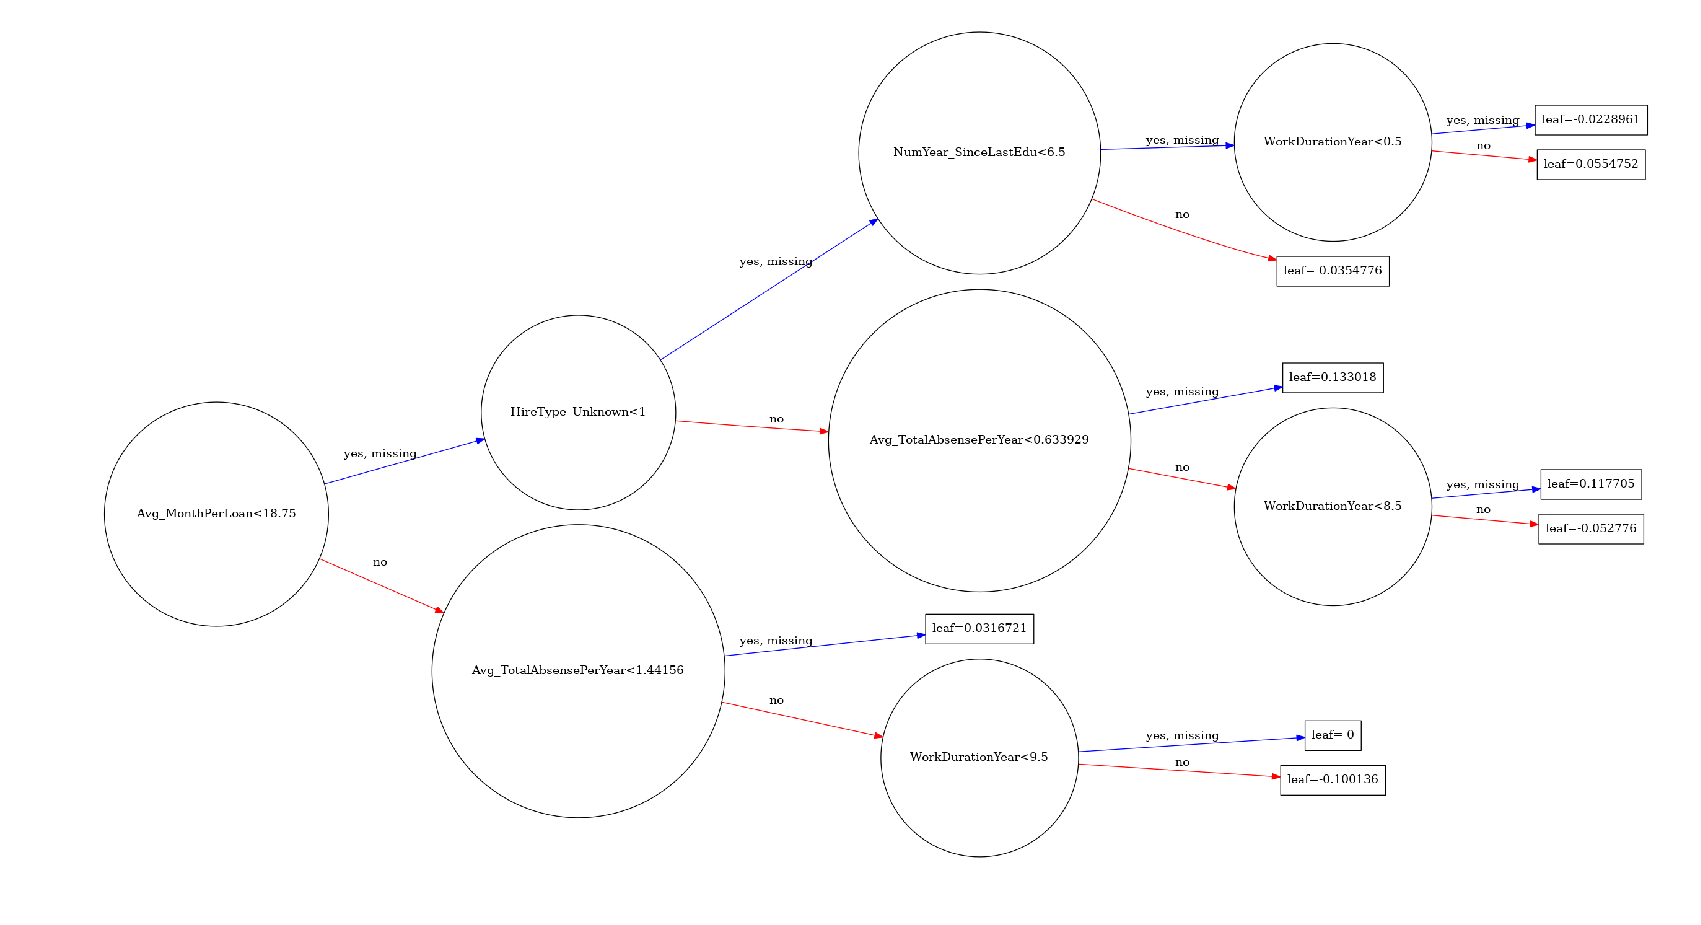

In [35]:
# View tree
# Because graphviz seams to have some resolution problem with pyplot and jupyter, we have to use to trick below to get a readable graph
# fig = plt.gcf()
# fig.set_size_inches(10, 10)
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)

# Plot the n-th tree of the model. Note that the model consists of many tress (as defined when creating the model)
plot_tree(model, num_trees=0, rankdir='LR', ax=ax)
# fig.savefig('tree.png')

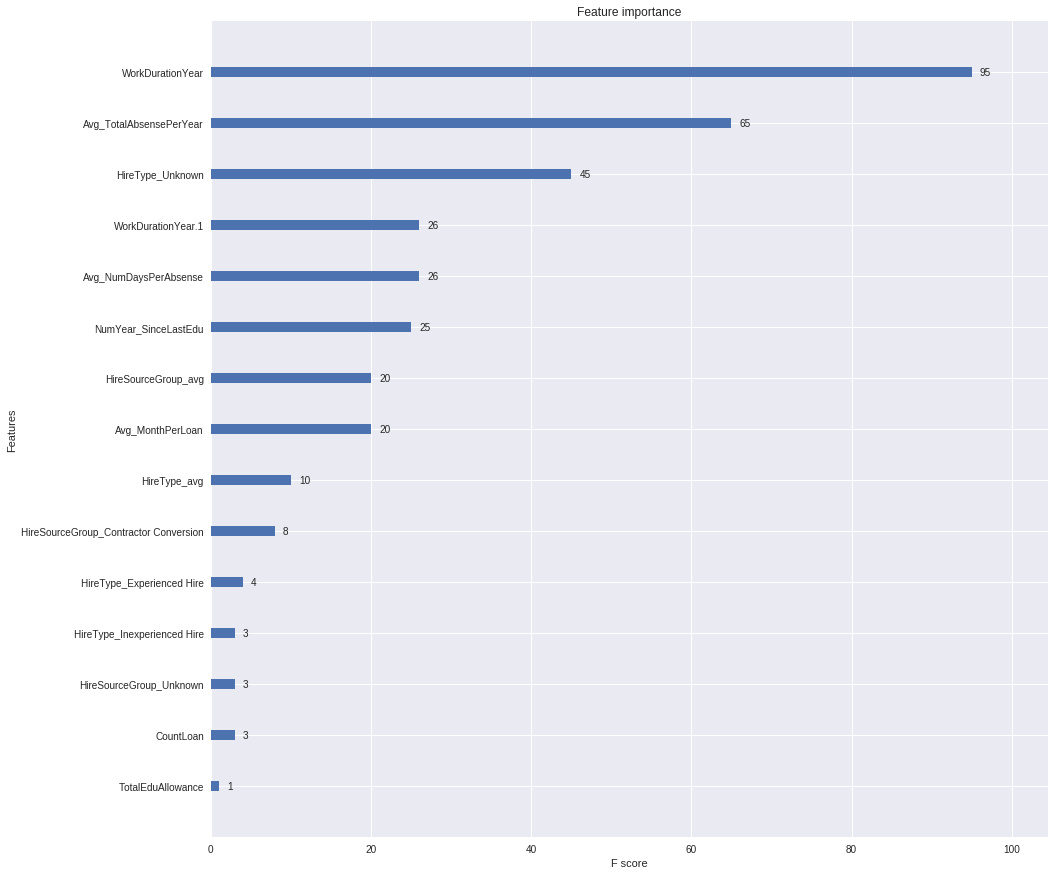

In [36]:
# Plot how many times each feature is used as node in the tree
plot_importance(model)